In [10]:
"""
## Installation et Import des Bibliothèques
"""

# %%
!pip install openpyxl  # Nécessaire pour lire les fichiers Excel
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [11]:
"""
## Fonctions d'Extraction et Prétraitement des Données
"""

# %%
def extract_article_data(file_path):
    """Extrait les données pour les articles depuis le fichier Excel"""
    xls = pd.ExcelFile(file_path)
    articles = {}

    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)

        # Nettoyage des données
        df = df.dropna(subset=['Date de sortie'])
        df['Sortie'] = df['Sortie'].abs()  # Conversion en valeurs positives

        # Extraction des dates et quantités
        dates = df['Date de sortie'].dt.strftime('%Y-%m-%d').tolist()
        quantities = df['Sortie'].tolist()

        lead_time = df['Lead Time Moyen'].dropna().tolist()
        lead_time = [int(lt) for lt in lead_time if isinstance(lt, (int, float))]

        # Paramètres de l'article
        params = {
            'lead_time': lead_time,
            'holding_cost': df['Cout de possession'].iloc[0],
            'shortage_cost': df['Cout Rupture'].iloc[0],
            'unit_cost': df['Cout d acquisition'].iloc[0],
            'fixed_order_cost': df['Cout fixe de commande'].iloc[0],
            'initial_stock': df['Stock disponible'].iloc[0]
        }

        articles[sheet_name] = {
            'dates': dates,
            'quantities': quantities,
            'params': params
        }

    return articles


In [12]:
def create_daily_series(dates, quantities, start_date=None, end_date=None):
    """Crée une série temporelle journalière avec des 0 pour les jours sans données"""
    df = pd.DataFrame({'dates': dates, 'quantities': quantities})
    df['dates'] = pd.to_datetime(df['dates'])

    if start_date is None:
        start_date = pd.to_datetime('2024-01-01')
    if end_date is None:
        end_date = pd.to_datetime('2024-12-31')

    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    daily_df = pd.DataFrame(index=date_range)

    result = daily_df.join(df.set_index('dates'), how='left')
    result['quantities'] = result['quantities'].fillna(0)

    return result['quantities'].tolist()

In [13]:

"""
## Fonctions de Simulation (Conservées telles quelles)
"""


def simulate_ts_policy(demand_series, lead_times, T, S, initial_stock, costs):
    """
    Simulation de la politique (T,S)

    Args:
        demand_series (list): Liste de la demande journalière.
        lead_times (list): Liste des délais de livraison.
        T (int): Période de révision.
        S (int): Niveau de recomplètement.
        initial_stock (int): Stock initial.
        costs (dict): Dictionnaire contenant:
            - holding_cost (float)
            - shortage_cost (float)
            - unit_cost (float)
            - fixed_order_cost (float)

    Returns:
        dict: Indicateurs de performance et coûts.
    """
    holding_cost = costs['holding_cost']
    shortage_cost = costs['shortage_cost']
    unit_cost = costs['unit_cost']
    fixed_order_cost = costs['fixed_order_cost']

    # Initialisation
    stock = initial_stock
    orders = []
    daily_physical_stock = [max(0, initial_stock)]
    total_shortage_units = 0
    total_delivered = 0
    total_orders = 0
    total_ordered_quantity = 0
    total_demand = sum(demand_series)
    days = len(demand_series)
    lead_index = 0

    for day in range(days):
        # Réception des commandes
        received = sum(qty for qty, remaining in orders if remaining == 1)
        stock += received
        total_ordered_quantity += received
        orders = [(qty, rem - 1) for qty, rem in orders if rem > 1]

        # Gestion de la demande
        demand = demand_series[day]
        delivered = min(stock, demand)
        stock -= delivered
        total_delivered += delivered
        shortage = max(0, demand - delivered)
        total_shortage_units += shortage

        # Politique de commande (T,S)
        if day % T == 0:
            pipeline = sum(qty for qty, _ in orders)
            if stock + pipeline < S:
                order_qty = S - (stock + pipeline)
                lead_time = lead_times[lead_index % len(lead_times)]
                lead_index += 1
                orders.append((order_qty, lead_time))
                total_orders += 1

        # Stock physique
        daily_physical_stock.append(max(0, stock))

    # Calcul des indicateurs de performance
    avg_stock = np.mean(daily_physical_stock)
    service_level = (1 - total_shortage_units / total_demand) * 100
    fill_rate = (total_delivered / total_demand) * 100
    stock_turnover = total_demand / avg_stock if avg_stock > 0 else 0
    # Calcul du stock de sécurité théorique (pour information)
    sigma_d = np.std(demand_series, ddof=1)
    L_mean = np.mean(lead_times)
    z = norm.ppf(0.95)  # Niveau de service cible fixé à 95%
    T_safety_stock = round(z * sigma_d * np.sqrt(L_mean + T))



    # Calcul des coûts
    holding_cost_total = sum(daily_physical_stock) * holding_cost
    passation_cost_total = total_orders * fixed_order_cost
    shortage_cost_total = total_shortage_units * shortage_cost
    acquisition_cost_total = total_ordered_quantity * unit_cost
    total_cost = holding_cost_total + passation_cost_total + shortage_cost_total + acquisition_cost_total

    return {
        'avg_stock': avg_stock,
        'service_level': service_level,
        'fill_rate': fill_rate,
        'stock_turnover': stock_turnover,
        'T_safety_stock': T_safety_stock,
        'total_cost': total_cost,
        'holding_cost_total': holding_cost_total,
        'passation_cost_total': passation_cost_total,
        'shortage_cost_total': shortage_cost_total,
        'acquisition_cost_total': acquisition_cost_total,
        'total_orders': total_orders,
        'total_delivered': total_delivered,
        'total_shortage_units': total_shortage_units,
        'total_ordered_quantity': total_ordered_quantity
    }

In [14]:
def simulate_rq_policy(demand_series, lead_times, R, Q, initial_stock, costs):
    """
    Simulation de la politique (R,Q)

    Args:
        demand_series (list): Liste de la demande journalière.
        lead_times (list): Liste des délais de livraison.
        R (int): Niveau de réapprovisionnement.
        Q (int): Quantité de commande fixe.
        initial_stock (int): Stock initial.
        costs (dict): Dictionnaire contenant:
            - holding_cost (float)
            - shortage_cost (float)
            - unit_cost (float)
            - fixed_order_cost (float)

    Returns:
        dict: Indicateurs de performance et coûts.
    """
    holding_cost = costs['holding_cost']
    shortage_cost = costs['shortage_cost']
    unit_cost = costs['unit_cost']
    fixed_order_cost = costs['fixed_order_cost']

    stock = initial_stock
    orders = []
    daily_physical_stock = [max(0, initial_stock)]
    total_shortage_units = 0
    total_delivered = 0
    total_orders = 0
    total_ordered_quantity = 0
    total_demand = sum(demand_series)
    days = len(demand_series)
    lead_index = 0

    for day in range(days):
        # Réception des commandes
        received = sum(qty for qty, remaining in orders if remaining == 1)
        stock += received
        total_ordered_quantity += received
        orders = [(qty, rem - 1) for qty, rem in orders if rem > 1]

        # Gestion de la demande
        demand = demand_series[day]
        delivered = min(stock, demand)
        stock -= delivered
        total_delivered += delivered
        shortage = max(0, demand - delivered)
        total_shortage_units += shortage

        # Politique de commande (R,Q)
        pipeline = sum(qty for qty, _ in orders)
        if stock + pipeline <= R:
            lead_time = lead_times[lead_index % len(lead_times)]
            lead_index += 1
            orders.append((Q, lead_time))
            total_orders += 1

        # Stock physique
        daily_physical_stock.append(max(0, stock))

    # Calcul des indicateurs de performance
    avg_stock = np.mean(daily_physical_stock)
    service_level = (1 - total_shortage_units / total_demand) * 100
    fill_rate = (total_delivered / total_demand) * 100
    stock_turnover = total_demand / avg_stock if avg_stock > 0 else 0
     # Estimation du stock de sécurité pour la politique (R,Q)
    mean_demand = np.mean(demand_series)
    std_demand = np.std(demand_series)
    avg_lead_time = np.mean(lead_times)
    z = norm.ppf(0.95)
    R_safety_stock = round(z * std_demand * np.sqrt(avg_lead_time))


    # Calcul des coûts
    holding_cost_total = sum(daily_physical_stock) * holding_cost
    passation_cost_total = total_orders * fixed_order_cost
    shortage_cost_total = total_shortage_units * shortage_cost
    acquisition_cost_total = total_ordered_quantity * unit_cost
    total_cost = holding_cost_total + passation_cost_total + shortage_cost_total + acquisition_cost_total

    return {
        'avg_stock': avg_stock,
        'service_level': service_level,
        'fill_rate': fill_rate,
        'stock_turnover': stock_turnover,
        'R_safety_stock': R_safety_stock,
        'total_cost': total_cost,
        'holding_cost_total': holding_cost_total,
        'passation_cost_total': passation_cost_total,
        'shortage_cost_total': shortage_cost_total,
        'acquisition_cost_total': acquisition_cost_total,
        'total_orders': total_orders,
        'total_delivered': total_delivered,
        'total_shortage_units': total_shortage_units,
        'total_ordered_quantity': total_ordered_quantity
    }


In [7]:
import numpy as np
from scipy.stats import norm


def calculate_eoq(demand_annuelle, fixed_order_cost, holding_cost):
    """
    Calcule la Quantité Économique de Commande (EOQ).

    Parameters:
        demand_annuelle (float): Demande annuelle moyenne
        fixed_order_cost (float): Coût fixe de passation d'une commande
        holding_cost (float): Coût de possession unitaire par an

    Returns:
        float: Quantité EOQ
    """
    if demand_annuelle <= 0 or fixed_order_cost <= 0 or holding_cost <= 0:
        return 0
    return np.sqrt((2 * demand_annuelle * fixed_order_cost) / holding_cost)


def improved_safety_stock(demandes, lead_times, service_level=0.95):
    """
    Calcule le stock de sécurité en tenant compte de la variabilité de la demande
    et du délai d'approvisionnement.

    Parameters:
        demandes (list/array): Historique des demandes journalières
        lead_times (list/array): Historique des délais d'approvisionnement
        service_level (float): Niveau de service souhaité (ex: 0.95)

    Returns:
        int: Stock de sécurité
    """
    mean_demand = np.mean(demandes)
    std_demand = np.std(demandes, ddof=1) if len(demandes) > 1 else 0

    mean_lead_time = np.mean(lead_times) if len(lead_times) > 0 else 1
    std_lead_time = np.std(lead_times, ddof=1) if len(lead_times) > 1 else 0

    z = norm.ppf(service_level)

    # Formule du SS avec variabilité croisée de la demande et du lead time
    safety_stock = z * np.sqrt(
        (mean_lead_time * std_demand ** 2) + (mean_demand * std_lead_time) ** 2
    )
    return max(1, int(np.ceil(safety_stock)))


def generate_parameter_ranges(data):
    """
    Génère des plages de valeurs pour simuler différents scénarios de gestion de stock.

    Parameters:
        data (dict): Données comprenant 'quantities', 'params'

    Returns:
        dict: R_values, Q_values, T_values, S_values
    """
    quantities = data.get('quantities', [])
    params = data.get('params', {})

    lead_times = params.get('lead_time', [1])
    holding_cost = params.get('holding_cost', 1)
    fixed_order_cost = params.get('fixed_order_cost', 100)
    demand_period = params.get('demand_period', 365)  # jours

    # Nettoyage des données
    quantities = [q for q in quantities if q > 0]
    lead_times = [lt for lt in lead_times if lt > 0]

    if not quantities:
        raise ValueError("Aucune donnée de demande valide fournie.")

    mean_demand_per_day = np.mean(quantities)
    std_demand = np.std(quantities, ddof=1) if len(quantities) > 1 else 0

    # Niveau de service
    service_level = params.get('service_level', 0.95)
    z = norm.ppf(service_level)

    # Moyenne ajustée du délai d'approvisionnement
    mean_lead_time = np.mean(lead_times) if lead_times else 1

    # Calcul du stock de sécurité
    safety_stock = improved_safety_stock(quantities, lead_times, service_level)
    safety_stock = max(safety_stock, 1)

    # Calcul de la demande annuelle estimée
    demand_annuelle = mean_demand_per_day * demand_period

    # Calcul de l'EOQ
    eoq = calculate_eoq(demand_annuelle, fixed_order_cost, holding_cost)
    eoq = max(1, int(eoq))

    # Plages de valeurs pour Q (Quantité commandée)
    Q_min = max(1, int(0.5 * eoq))
    Q_max = int(1.5 * eoq)
    Q_values = np.linspace(Q_min, Q_max, 20).astype(int)

    # Point de commande ROP = μ × LT + SS
    expected_demand_during_lt = mean_demand_per_day * mean_lead_time
    R_min = max(0, int(expected_demand_during_lt - safety_stock))
    R_max = int(expected_demand_during_lt + safety_stock)
    R_values = np.unique(np.linspace(R_min, R_max, 20).astype(int))

    # Période de revue T (en jours)
    mean_T_days = int(eoq / mean_demand_per_day) if mean_demand_per_day > 0 else 30
    T_min = max(1, int(0.5 * mean_T_days))
    T_max = max(1, int(1.5 * mean_T_days))  # Limite à 30 jours si trop grand
    T_values = np.linspace(T_min, T_max, 20).astype(int)

    # Niveau cible S = μ × (T + L) + SS
    S_min = round(mean_demand_per_day * (T_min + mean_lead_time) * 0.5)
    S_max = round(mean_demand_per_day * (T_max + mean_lead_time) * 1.5)
    S_values = np.linspace(S_min, S_max, 20).astype(int)

    return R_values, Q_values, T_values, S_values

In [15]:
def monte_carlo_simulation(article_data, nb_simulations=3):
    demand_series = create_daily_series(article_data['dates'], article_data['quantities'])
    params = article_data['params']

    R_values, Q_values, T_values, S_values = generate_parameter_ranges(article_data)
    lead_times = params['lead_time']

    results = []

    # Pour chaque combinaison de paramètres
    for R in R_values:
        for Q in Q_values:
            rq_kpis = []
            for _ in range(nb_simulations):
                result = simulate_rq_policy(
                    demand_series,
                    lead_times,
                    R, Q,
                    params['initial_stock'],
                    {
                        'holding_cost': params['holding_cost'],
                        'shortage_cost': params['shortage_cost'],
                        'unit_cost': params['unit_cost'],
                        'fixed_order_cost': params['fixed_order_cost']
                    }
                )
                rq_kpis.append(result)

            # Moyenne des KPIs pour cette combinaison RQ
            rq_avg = {
                'R': R, 'Q': Q,
                'rq_cost': np.mean([r['total_cost'] for r in rq_kpis]),
                'rq_total_holding_cost': np.mean([r['holding_cost_total'] for r in rq_kpis]),
                'rq_passation_cost': np.mean([r['passation_cost_total'] for r in rq_kpis]),
                'rq_shortage_cost': np.mean([r['shortage_cost_total'] for r in rq_kpis]),
                'rq_service': np.mean([r['service_level'] for r in rq_kpis]),
                'rq_fill_rate': np.mean([r['fill_rate'] for r in rq_kpis]),
                'rq_rotation': np.mean([r['stock_turnover'] for r in rq_kpis]),
                'rq_avg_stock': np.mean([r['avg_stock'] for r in rq_kpis])
            }
            results.append(rq_avg)

    for T in T_values:
        for S in S_values:
            ts_kpis = []
            for _ in range(nb_simulations):
                result = simulate_ts_policy(
                    demand_series,
                    lead_times,
                    T, S,
                    params['initial_stock'],
                    {
                        'holding_cost': params['holding_cost'],
                        'shortage_cost': params['shortage_cost'],
                        'unit_cost': params['unit_cost'],
                        'fixed_order_cost': params['fixed_order_cost']
                    }
                )
                ts_kpis.append(result)

            # Moyenne des KPIs pour cette combinaison TS
            ts_avg = {
                'T': T, 'S': S,
                'ts_cost': np.mean([r['total_cost'] for r in ts_kpis]),
                'ts_total_holding_cost': np.mean([r['holding_cost_total'] for r in ts_kpis]),
                'ts_passation_cost': np.mean([r['passation_cost_total'] for r in ts_kpis]),
                'ts_shortage_cost': np.mean([r['shortage_cost_total'] for r in ts_kpis]),
                'ts_service': np.mean([r['service_level'] for r in ts_kpis]),
                'ts_fill_rate': np.mean([r['fill_rate'] for r in ts_kpis]),
                'ts_rotation': np.mean([r['stock_turnover'] for r in ts_kpis]),
                'ts_avg_stock': np.mean([r['avg_stock'] for r in ts_kpis])
            }
            results.append(ts_avg)

    results_df = pd.DataFrame(results)



    return results_df, R_values, Q_values, T_values, S_values



=== Analyse pour l'article: ELECTRODE ===

--- Paramètres initiaux ---
- Stock initial: 835.0
- Coût de possession: 0.12 MAD/unité/jour
- Coût de rupture: 1.80 MAD/unité manquante
- Coût d'acquisition: 0.60 MAD/unité
- Coût fixe de commande: 100.00 MAD/commande
- Lead Time Moyen: 8.50 jours

--- Simulation Monte Carlo ---
       R       Q    rq_cost  rq_total_holding_cost  rq_passation_cost  \
0  902.0  5578.0  189976.48              176189.28              400.0   
1  902.0  6165.0  206022.60              193507.80              300.0   
2  902.0  6752.0  227904.72              215451.12              300.0   
3  902.0  7339.0  250044.60              235827.00              300.0   
4  902.0  7926.0  267450.48              252883.68              300.0   

   rq_shortage_cost  rq_service  rq_fill_rate  rq_rotation  rq_avg_stock   T  \
0               0.0  100.000000    100.000000     4.620785   3764.728205 NaN   
1            1117.8   96.430214     96.430214     4.207235   4134.782051 NaN

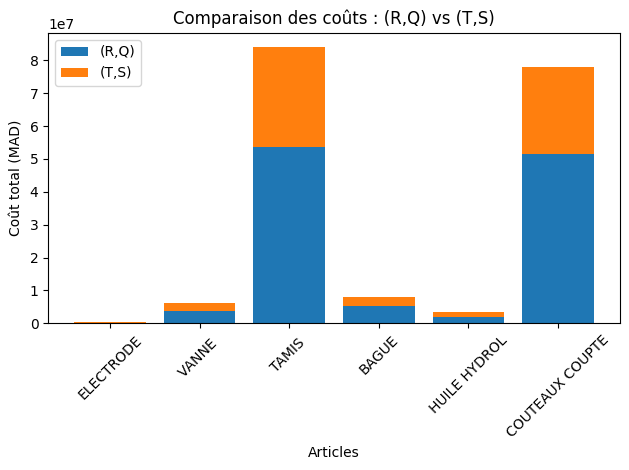

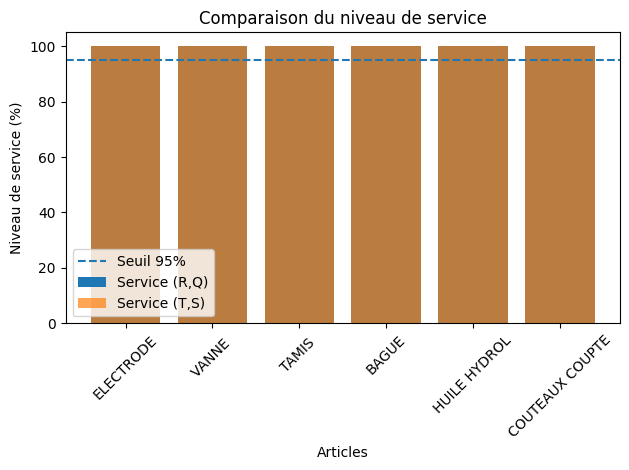

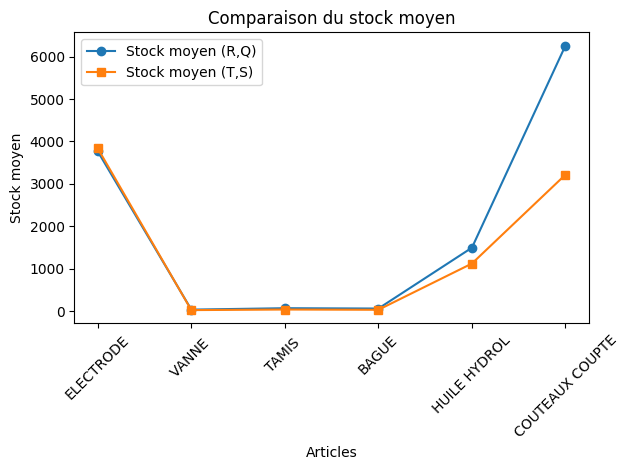

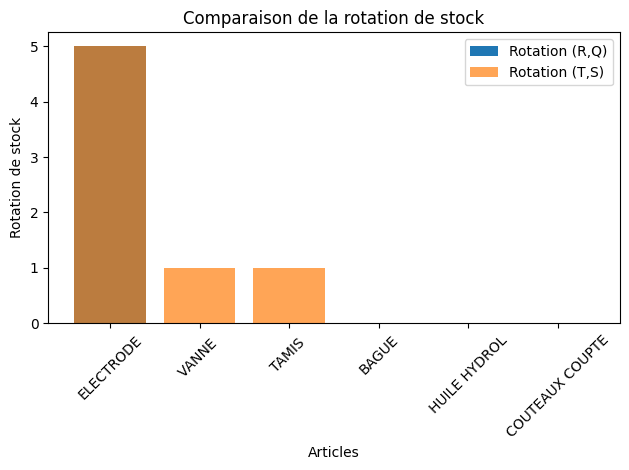

In [17]:
import pandas as pd
import numpy as np
import itertools

def find_best_solution(proposals, target_service=100):
    """
    Trouve la meilleure solution selon le service level cible
    - Sélectionne d'abord toutes les solutions avec service ≥ 95%
    - Parmi ces solutions, retourne celle avec le coût minimal
    - Si aucune solution ≥ 95%, retourne la plus proche au-dessus
    - Si aucune solution au-dessus, retourne la plus proche en dessous
    """
    # 1. Filtrer les solutions avec service ≥ 95%
    admissible_solutions = [p for p in proposals if p['service'] >= target_service]

    if admissible_solutions:
        # 2. Retourner la solution avec le coût minimal parmi les admissibles
        return min(admissible_solutions, key=lambda x: x['cost'])

    # 3. Si aucune solution ≥ 95%, chercher la plus proche au-dessus
    above_solutions = [p for p in proposals if p['service'] > target_service]
    if above_solutions:
        closest_above = min(above_solutions, key=lambda x: (x['service'], x['cost']))
        return closest_above

    # 4. Sinon, prendre la plus proche en dessous avec le meilleur coût
    closest_below = min(proposals,
                       key=lambda x: (abs(x['service'] - target_service), x['cost']))
    return closest_below

def analyze_all_articles(file_path):
    """Analyse complète pour tous les articles"""
    articles_data = extract_article_data(file_path)
    results = {}
    summary_data = []

    for article_name, data in articles_data.items():
        print(f"\n=== Analyse pour l'article: {article_name} ===")
        demand_series = create_daily_series(data['dates'], data['quantities'])
         # Augmenter la demande
        #demand_series = [q * 1.5 for q in demand_series]

        params = data['params']

        lead_times = params['lead_time']
        initial_stock = params['initial_stock']
        costs = {
            'holding_cost': params['holding_cost'],
            'shortage_cost': params['shortage_cost'],
            'unit_cost': params['unit_cost'],
            'fixed_order_cost': params['fixed_order_cost']
        }

        mc_results, R_values, Q_values, T_values, S_values = monte_carlo_simulation(data)


        # Grid search for (R, Q)
        rq_proposals = []
        for R, Q in itertools.product(R_values, Q_values):
            rq_result = simulate_rq_policy(demand_series, lead_times, R, Q, initial_stock, costs)
            rq_proposals.append({
                'R': R, 'Q': Q,
                'cost': rq_result['total_cost'],
                'service': rq_result['service_level'],
                'fill_rate': rq_result['fill_rate'],
                'rotation': rq_result['stock_turnover'],
                'avg_stock': rq_result['avg_stock'],
                'safety_stock': rq_result['R_safety_stock']
            })

        rq_best = find_best_solution(rq_proposals)
        best_rq = {
            'R': rq_best['R'], 'Q': rq_best['Q'],
            'rq_cost': rq_best['cost'],
            'rq_service': rq_best['service'],
            'rq_fill_rate': rq_best['fill_rate'],
            'rq_rotation': rq_best['rotation'],
            'rq_avg_stock': rq_best['avg_stock'],
            'R_safety_stock': rq_best['safety_stock']
        }

        # Grid search for (T, S)
        ts_proposals = []
        for T, S in itertools.product(T_values, S_values):
            ts_result = simulate_ts_policy(demand_series, lead_times, T, S, initial_stock, costs)
            ts_proposals.append({
                'T': T, 'S': S,
                'cost': ts_result['total_cost'],
                'service': ts_result['service_level'],
                'fill_rate': ts_result['fill_rate'],
                'rotation': ts_result['stock_turnover'],
                'avg_stock': ts_result['avg_stock'],
                'safety_stock': ts_result['T_safety_stock']
            })

        ts_best = find_best_solution(ts_proposals)
        best_ts = {
            'T': ts_best['T'], 'S': ts_best['S'],
            'ts_cost': ts_best['cost'],
            'ts_service': ts_best['service'],
            'ts_fill_rate': ts_best['fill_rate'],
            'ts_rotation': ts_best['rotation'],
            'ts_avg_stock': ts_best['avg_stock'],
            'T_safety_stock': ts_best['safety_stock']
        }

        # Enregistrer les résultats (le reste du code reste inchangé)
        results[article_name] = {
            'best_rq': best_rq,
            'best_ts': best_ts,
            'all_results': mc_results.to_dict('records'),
            'R_values': R_values,
            'Q_values': Q_values,
            'T_values': T_values,
            'S_values': S_values
        }


        # Affichage des résultats
        # Affichage des paramètres initiaux
        print("\n--- Paramètres initiaux ---")
        print(f"- Stock initial: {data['params']['initial_stock']}")
        print(f"- Coût de possession: {data['params']['holding_cost']:.2f} MAD/unité/jour")
        print(f"- Coût de rupture: {data['params']['shortage_cost']:.2f} MAD/unité manquante")
        print(f"- Coût d'acquisition: {data['params']['unit_cost']:.2f} MAD/unité")
        print(f"- Coût fixe de commande: {data['params']['fixed_order_cost']:.2f} MAD/commande")
        print(f"- Lead Time Moyen: {np.mean(data['params']['lead_time']):.2f} jours")

        print("\n--- Simulation Monte Carlo ---")
        print(mc_results.head())


        print("\n--- Résultats de l'analyse ---")
        print("\n--- Propositions testées (R,Q) ---")
        for p in rq_proposals:
            print(f"R={p['R']}, Q={p['Q']}, Cost={p['cost']:.2f}, Service={p['service']:.2f}%")



        print("\nMeilleure politique (R,Q):")
        print(f"- R = {best_rq['R']}, Q = {best_rq['Q']}")
        print(f"- Coût total: {best_rq['rq_cost']:.2f} MAD")
        print(f"- Niveau de service: {best_rq['rq_service']:.2f}%")
        print(f"- Fill Rate: {best_rq['rq_fill_rate']:.2f}")
        print(f"- Rotation de stock: {best_rq['rq_rotation']:.2f}")
        print(f"- Stock physique moyen: {best_rq['rq_avg_stock']:.2f}")
        print(f"- Stock de sécurité (R,Q): {best_rq['R_safety_stock']:.2f}")




        # Print R_values and Q_values
        print("\nR_values:", R_values)
        print("\nQ_values:", Q_values)

        print("\n--- Propositions testées (T,S) ---")
        for p in ts_proposals:
            print(f"T={p['T']}, S={p['S']}, Cost={p['cost']:.2f}, Service={p['service']:.2f}%")

        print("\nMeilleure politique (T,S):")
        print(f"- T = {best_ts['T']}, S = {best_ts['S']}")
        print(f"- Coût total: {best_ts['ts_cost']:.2f} MAD")
        print(f"- Niveau de service: {best_ts['ts_service']:.2f}%")
        print(f"- Fill Rate: {best_ts['ts_fill_rate']:.2f}")
        print(f"- Rotation de stock: {best_ts['ts_rotation']:.2f}")
        print(f"- Stock physique moyen: {best_ts['ts_avg_stock']:.2f}")
        print(f"- Stock de sécurité (T,S): {best_ts['T_safety_stock']:.2f}")

        # Print T_values and S_values
        print("\nT_values:", T_values)
        print("\nS_values:", S_values)



        # Append data for the summary table
        summary_data.append([
            article_name,
            best_rq['R'], best_rq['Q'], round(best_rq['rq_cost'], 1), round(best_rq['rq_service'], 1), round(best_rq['R_safety_stock'], 1),
            best_ts['T'], best_ts['S'], round(best_ts['ts_cost'], 1), round(best_ts['ts_service'], 1), round(best_ts['T_safety_stock'], 1),
            best_rq['rq_avg_stock'], best_ts['ts_avg_stock'],
            round(best_rq['rq_rotation']), round(best_ts['ts_rotation'])  # Add these lines

        ])

    # Créer le tableau récapitulatif final
    summary_table = pd.DataFrame(
        summary_data,
        columns=[
            'Article',
            'R', 'Q', 'Coût (R,Q)', 'Service Level (R,Q)', 'Stock Sécurité (R,Q)',
            'T', 'S', 'Coût (T,S)', 'Service Level (T,S)', 'Stock Sécurité (T,S)',
            'rq_avg_stock', 'ts_avg_stock',
            'Rotation Stock (R,Q)', 'Rotation Stock (T,S)'  # Add these lines

        ]
    )

    print("\n--- Tableau récapitulatif des résultats ---")
    print(summary_table)

    return results, summary_table

def plot_summary_results(summary_table):
    """
    Génère les graphiques principaux pour le PFE
    """

    # 1️⃣ Comparaison des coûts
    plt.figure()
    plt.bar(summary_table['Article'], summary_table['Coût (R,Q)'], label='(R,Q)')
    plt.bar(summary_table['Article'], summary_table['Coût (T,S)'],
            bottom=summary_table['Coût (R,Q)'], label='(T,S)')
    plt.xlabel("Articles")
    plt.ylabel("Coût total (MAD)")
    plt.title("Comparaison des coûts : (R,Q) vs (T,S)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2️⃣ Niveau de service
    plt.figure()
    plt.bar(summary_table['Article'], summary_table['Service Level (R,Q)'], label='Service (R,Q)')
    plt.bar(summary_table['Article'], summary_table['Service Level (T,S)'],
            alpha=0.7, label='Service (T,S)')
    plt.axhline(95, linestyle='--', label='Seuil 95%')
    plt.xlabel("Articles")
    plt.ylabel("Niveau de service (%)")
    plt.title("Comparaison du niveau de service")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3️⃣ Stock moyen
    plt.figure()
    plt.plot(summary_table['Article'], summary_table['rq_avg_stock'],
             marker='o', label='Stock moyen (R,Q)')
    plt.plot(summary_table['Article'], summary_table['ts_avg_stock'],
             marker='s', label='Stock moyen (T,S)')
    plt.xlabel("Articles")
    plt.ylabel("Stock moyen")
    plt.title("Comparaison du stock moyen")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 4️⃣ Rotation de stock
    plt.figure()
    plt.bar(summary_table['Article'], summary_table['Rotation Stock (R,Q)'], label='Rotation (R,Q)')
    plt.bar(summary_table['Article'], summary_table['Rotation Stock (T,S)'],
            alpha=0.7, label='Rotation (T,S)')
    plt.xlabel("Articles")
    plt.ylabel("Rotation de stock")
    plt.title("Comparaison de la rotation de stock")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



"""
## Exécution de l'Analyse
"""



# %%
# Analyse des données
file_path = "/content/drive/MyDrive/Colab PFE doc/FINALE  (1).xlsx"

results, summary_table = analyze_all_articles(file_path)
plot_summary_results(summary_table)



In [18]:
# prompt: resumé les résulats de tous les score de RQ et TS tableau

print("\n--- Tableau récapitulatif des résultats ---")
summary_table



--- Tableau récapitulatif des résultats ---


,Article,R,Q,"Coût (R,Q)","Service Level (R,Q)","Stock Sécurité (R,Q)",T,S,"Coût (T,S)","Service Level (T,S)","Stock Sécurité (T,S)",rq_avg_stock,ts_avg_stock,"Rotation Stock (R,Q)","Rotation Stock (T,S)"
0,ELECTRODE,902,5578,189976.5,100.0,453,32,4887,191556.2,100.0,991,3764.728205,3835.671795,5,5
1,VANNE,39,10,3622973.9,100.0,3,21,31,2544745.3,100.0,3,38.146739,26.750000,0,1
2,TAMIS,107,3,53740539.5,100.0,5,6,60,30427894.6,100.0,5,71.358696,40.380435,0,1
3,BAGUE,75,10,5240332.0,100.0,2,26,42,2816985.9,100.0,2,63.524457,34.171196,0,0
4,HUILE HYDROL,1406,1244,2000509.2,100.0,67,11,1147,1501920.5,100.0,108,1497.051771,1123.956403,0,0
5,COUTEAUX COUPTE,8499,289,51410617.9,100.0,192,7,4350,26437760.5,100.0,200,6260.078378,3218.108108,0,0
